<a href="https://colab.research.google.com/github/tshabalalasibongile/Dimensionality-Reduction/blob/main/week5_spatio_assignment_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sibongile Tshabalala (2356121)

# Week 5:Dimensionality Reduction

# Install






In [ ]:
!pip install yellowbrick

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.colors as ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# **Parameters**

In [ ]:
CSV_PATH ="Processed_Assen_RS_data.csv"
size = (172, 284) #(rows, cols)
bands = ['Band1','Band2','Band3','Band4','Band5','Band6','Band7']
coord_names = ['Longitude', 'Latitude']
eps = 1e-9

# **Load and Inspect Data**

In [ ]:
#load dataset
input_data = pd.read_csv(CSV_PATH)

print("Dataset shape:", input_data.shape)
display(input_data.head())
print("\nMissing values per column:")
display(input_data.isna().sum())

expected = size[0]*size[1]
if input_data.shape[0] != expected:
  raise AssertionError(f"Row count {input_data.shape[0]} !-{expected}. Update 'size' or check CSV")


Dataset shape: (48848, 10)


,Unnamed: 0,Longitude,Latitude,Band1,Band2,Band3,Band4,Band5,Band6,Band7
0,0,27.564250,-25.105965,188,227,363,406,750,709,440
1,1,27.564548,-25.105963,126,144,215,166,917,479,232
2,2,27.564845,-25.105962,141,187,421,310,2263,947,438
3,3,27.565143,-25.105961,111,170,402,291,2558,1154,562
4,4,27.565440,-25.105960,232,365,658,779,2409,2199,1319



Missing values per column:


,0
Unnamed: 0,0
Longitude,0
Latitude,0
Band1,0
Band2,0
Band3,0
Band4,0
Band5,0
Band6,0
Band7,0


# **Basic Data Preprocessing**

In [ ]:
for c in coord_names + bands:
  input_data[c] = pd.to_numeric(input_data[c], errors='coerce')

In [ ]:
#Fill NaNs in bands
if input_data[bands].isna().any().any():
  input_data[bands] = input_data[bands].fillna(input_data[bands].mean())

In [ ]:
#Drop NaNs in coordinates
if input_data[coord_names].isna().any(axis=None):
  input_data.dropna(subset=coord_names).reset_index(drop=True)
  if input_data.shape[0] != expected:
    print("Warning: row count changed after dropping coords.")

In [ ]:
#Checking for missing pixels
print("Missing pixels in bands:", input_data.isnull().values.any())

Missing pixels in bands: False


In [ ]:
#Convert to numeric
input_data['Latitude'] = pd.to_numeric(input_data['Latitude'], errors='coerce')
input_data['Longitude'] = pd.to_numeric(input_data['Longitude'], errors='coerce')

for band in bands:
    input_data[band] = pd.to_numeric(input_data[band], errors='coerce')

input_data.describe()

,Unnamed: 0,Longitude,Latitude,Band1,Band2,Band3,Band4,Band5,Band6,Band7
count,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000
mean,24423.500000,27.606466,-25.128960,251.722547,316.526327,509.547433,609.615419,1648.147539,1801.414490,1216.814609
std,14101.347312,0.024398,0.013452,94.493587,106.311331,145.656643,238.682890,446.999961,469.584012,432.462650
min,0.000000,27.564250,-25.152291,0.000000,62.000000,149.000000,121.000000,150.000000,141.000000,102.000000
25%,12211.750000,27.585356,-25.140607,186.000000,248.000000,436.000000,467.000000,1382.000000,1539.000000,937.750000
50%,24423.500000,27.606466,-25.128958,245.000000,312.000000,498.000000,577.000000,1585.000000,1830.000000,1196.000000
75%,36635.250000,27.627580,-25.117309,312.000000,377.000000,562.000000,706.000000,1865.000000,2070.000000,1454.000000
max,48847.000000,27.648697,-25.105620,968.000000,1171.000000,1834.000000,2558.000000,5025.000000,4031.000000,3158.000000


# **Basic Exploratory Data Analysis**

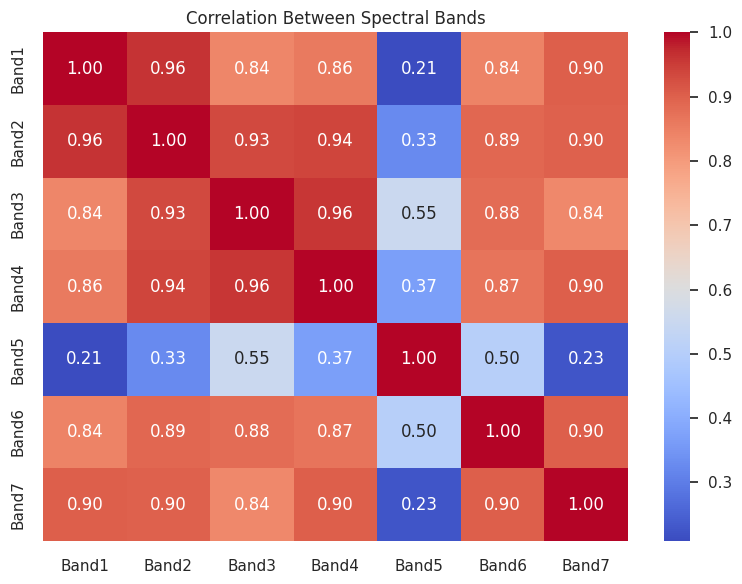

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(input_data[bands].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Spectral Bands")
plt.tight_layout()
plt.show()

# **Compute NDVI and NDWI**

In [ ]:
#Compute indices (safe division)
NIR = input_data['Band5'].astype(float)
R   = input_data['Band4'].astype(float)
G   = input_data['Band3'].astype(float)

input_data['NDVI'] = (NIR - R) / (NIR + R + eps)
input_data['NDWI'] = (G - NIR) / (G + NIR + eps)

In [ ]:
# reshape NDVI/NDWI for later plotting (only if shape matches)
ndvi_arr = input_data['NDVI'].values.reshape(size)
ndwi_arr = input_data['NDWI'].values.reshape(size)

# **Standardize and Apply PCA**

Explained variance ratio: [0.8066 0.1365 0.0269]
Cumulative explained variance ratio: 0.9699


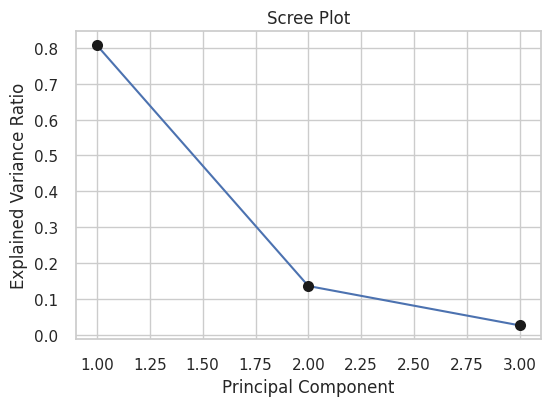

,PC1,PC2,PC3
Band1,0.390607,-0.262086,0.043755
Band2,0.410420,-0.130664,-0.225647
Band3,0.405620,0.151881,-0.456415
Band4,0.405092,-0.056430,-0.416533
Band5,0.188977,0.909004,0.080227
Band6,0.399223,0.091384,0.607492
Band7,0.394036,-0.230969,0.435742


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_data[bands].values)

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_data = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])

#Variance explained
print("Explained variance ratio:", np.round(pca.explained_variance_ratio_,4))
print("Cumulative explained variance ratio:", round(pca.explained_variance_ratio_.sum(),4))

#Scree plot
plt.figure(figsize=(6,4))
x = np.arange(1, 4)
y = pca.explained_variance_ratio_
plt.plot(x, y, marker='o', markersize=8, markerfacecolor='k')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()

#PCA Loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=bands)
display(loadings.style.background_gradient(cmap='coolwarm'))

# **Spatial PC maps**

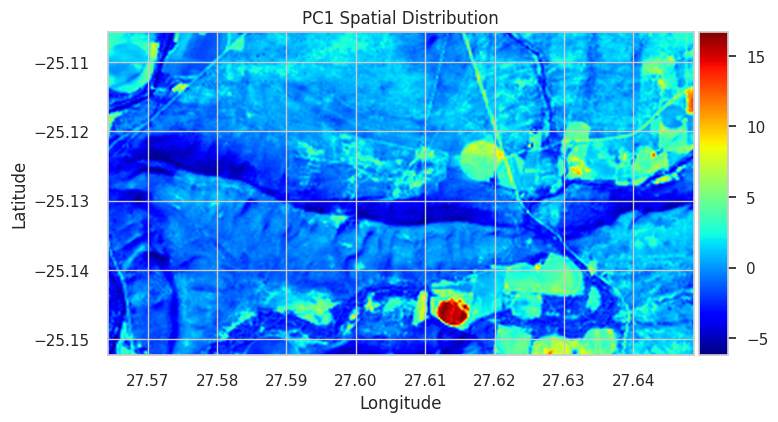

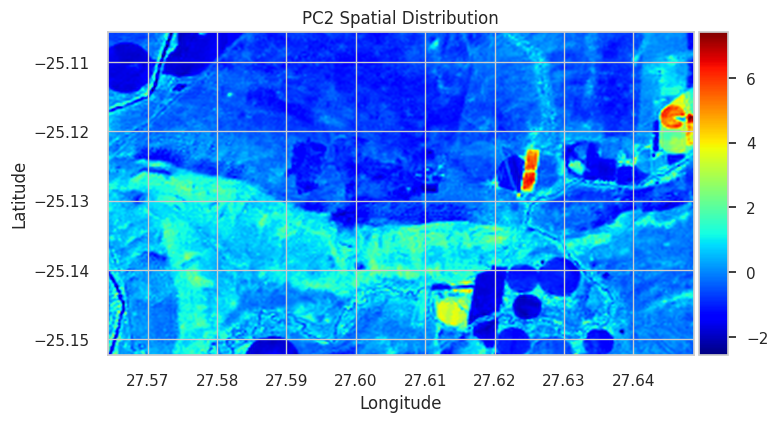

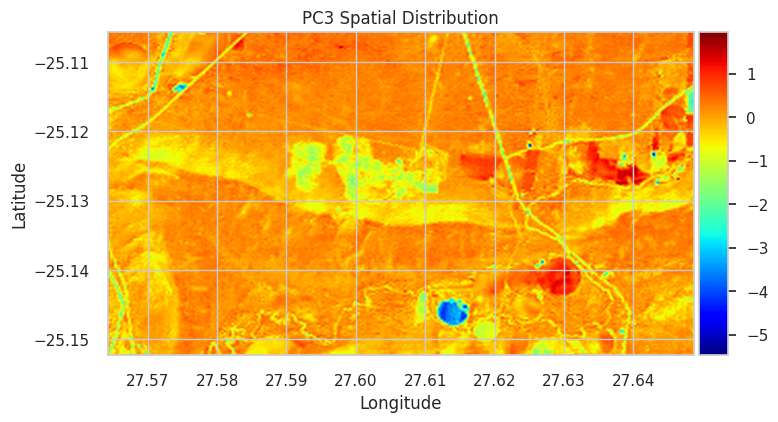

In [ ]:
xmin = input_data['Longitude'].min()
xmax = input_data['Longitude'].max()
ymin = input_data['Latitude'].min()
ymax = input_data['Latitude'].max()

for pc in ['PC1','PC2','PC3']:
  map = pca_data[pc].values.reshape(size)
  fig, ax = plt.subplots(figsize=(8, 8))
  im = ax.imshow(map, cmap="jet", extent = [xmin, xmax, ymin, ymax], origin='lower', interpolation = 'lanczos')
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  ax.set_title(f"{pc} Spatial Distribution")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, cax=cax)
  plt.show()


# **Determine Optimal K using Elbow Method**

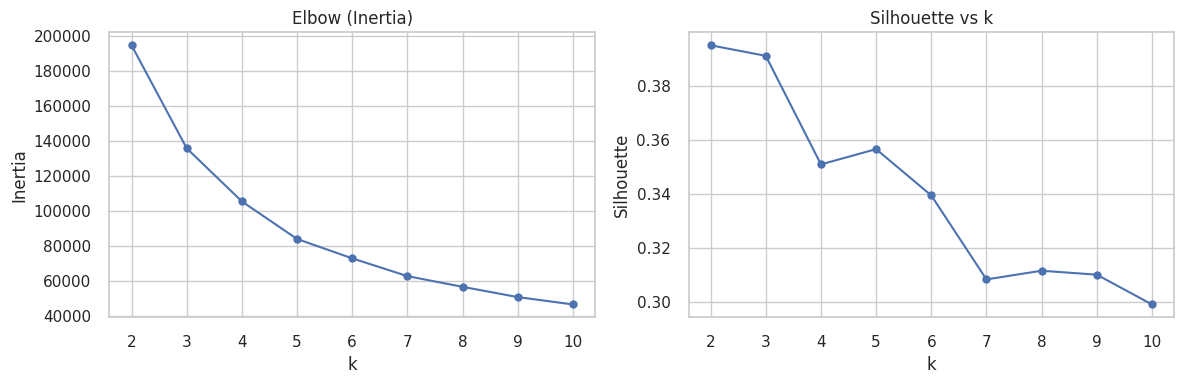

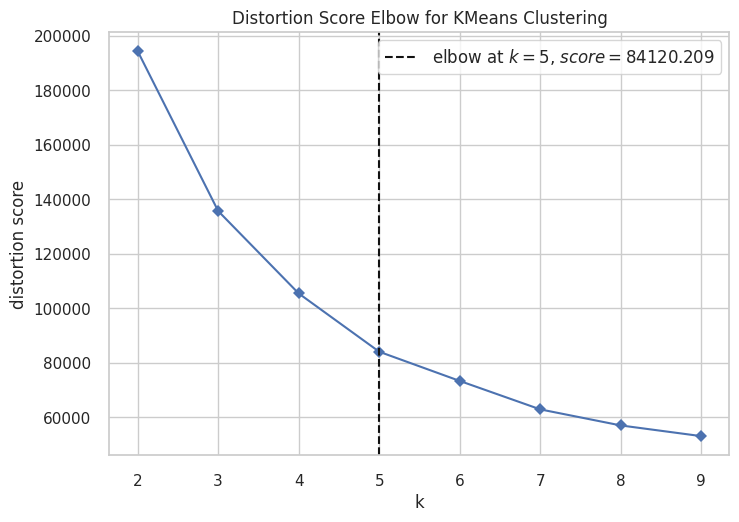

Yellowbrick elbow gave k = 5
Final chosen k: 5


In [ ]:
inertias = []
sil_scores = []
ks = list(range(2,11))
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ks, inertias, marker='o')
ax[0].set_title('Elbow (Inertia)')
ax[0].set_xlabel('k'); ax[0].set_ylabel('Inertia')
ax[1].plot(ks, sil_scores, marker='o')
ax[1].set_title('Silhouette vs k')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette')
plt.tight_layout()
plt.show()

best_k = None
try:
    viz = KElbowVisualizer(KMeans(random_state=42), k=(2,10), timings=False)
    viz.fit(X_scaled)
    viz.show(outpath=None)
    best_k = viz.elbow_value_
    print("Yellowbrick elbow gave k =", best_k)
except:
    best_k = ks[int(np.argmax(sil_scores))]
    print("Fallback chosen k (max silhouette):", best_k)

k_final = best_k
print("Final chosen k:", k_final)

# **K-Means Clustering (Original vs PCA Data)**

In [ ]:
# K-Means Clustering (Original vs PCA Data)
kmeans_original = KMeans(n_clusters=k_final, random_state=42, n_init=50).fit(X_scaled)
kmeans_pca = KMeans(n_clusters=k_final, random_state=42, n_init=50).fit(X_pca)

# Removed code from here
labels_original = kmeans_original.labels_
labels_pca = kmeans_pca.labels_

silhouette_original = silhouette_score(X_scaled, labels_original)
silhouette_pca = silhouette_score(X_pca, labels_pca)

print(f"Silhouette Score (Original Data): {silhouette_original:.3f}")
print(f"Silhouette Score (PCA Data): {silhouette_pca:.3f}")

Silhouette Score (Original Data): 0.357
Silhouette Score (PCA Data): 0.384


In [ ]:
#Cluster size
sizes = pd.DataFrame({
    'cluster': range(k_final),
    'size_original': [int((labels_original==i).sum()) for i in range(k_final)],
    'size_pca': [int((labels_pca==i).sum()) for i in range(k_final)]
})
display(sizes)

,cluster,size_original,size_pca
0,0,18447,4713
1,1,17025,17058
2,2,231,8347
3,3,4756,18499
4,4,8389,231


In [ ]:
#Align PCA labels
cm = contingency_matrix(labels_original, labels_pca)
row_ind, col_ind = linear_sum_assignment(-cm)
labels_pca_aligned = np.vectorize(lambda x: pca_to_original.get(x, x))(labels_pca)

In [ ]:
#Comparison dataframe
comparison = pd.DataFrame({
    "cluster": range(k_final),
    "size_original": sizes['size_original'],
    "size_pca_aligned": [int((labels_pca_aligned==i).sum()) for i in range(k_final)]
})
display(comparison)

,cluster,size_original,size_pca_aligned
0,0,18447,18499
1,1,17025,17058
2,2,231,231
3,3,4756,4713
4,4,8389,8347


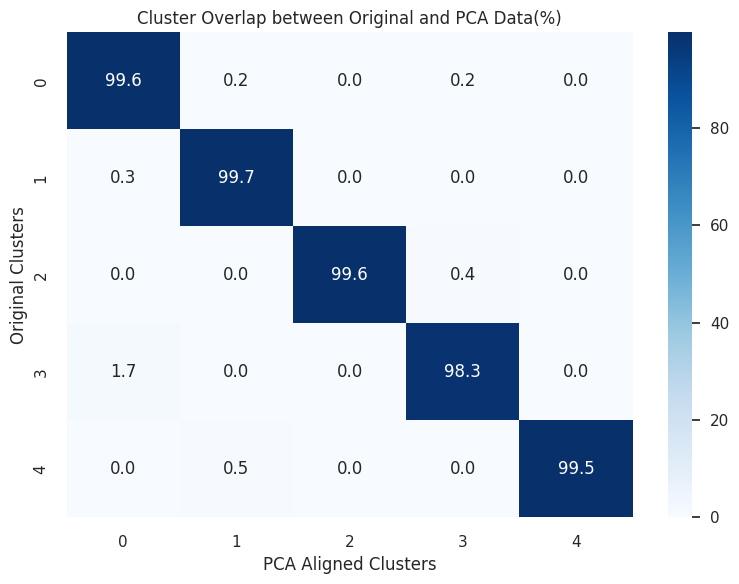

In [ ]:
#Overlap heatmap
input_data['Cluster_Original'] = labels_original
input_data['Cluster_PCA_Aligned'] = labels_pca_aligned

overlap = pd.crosstab(input_data['Cluster_Original'], input_data['Cluster_PCA_Aligned'], normalize='index')*100

plt.figure(figsize=(8, 6))
sns.heatmap(overlap, annot=True, cmap="Blues", fmt=".1f")
plt.title("Cluster Overlap between Original and PCA Data(%)")
plt.xlabel("PCA Aligned Clusters")
plt.ylabel("Original Clusters")
plt.tight_layout()
plt.show()

# **Spatial Cluster Maps**

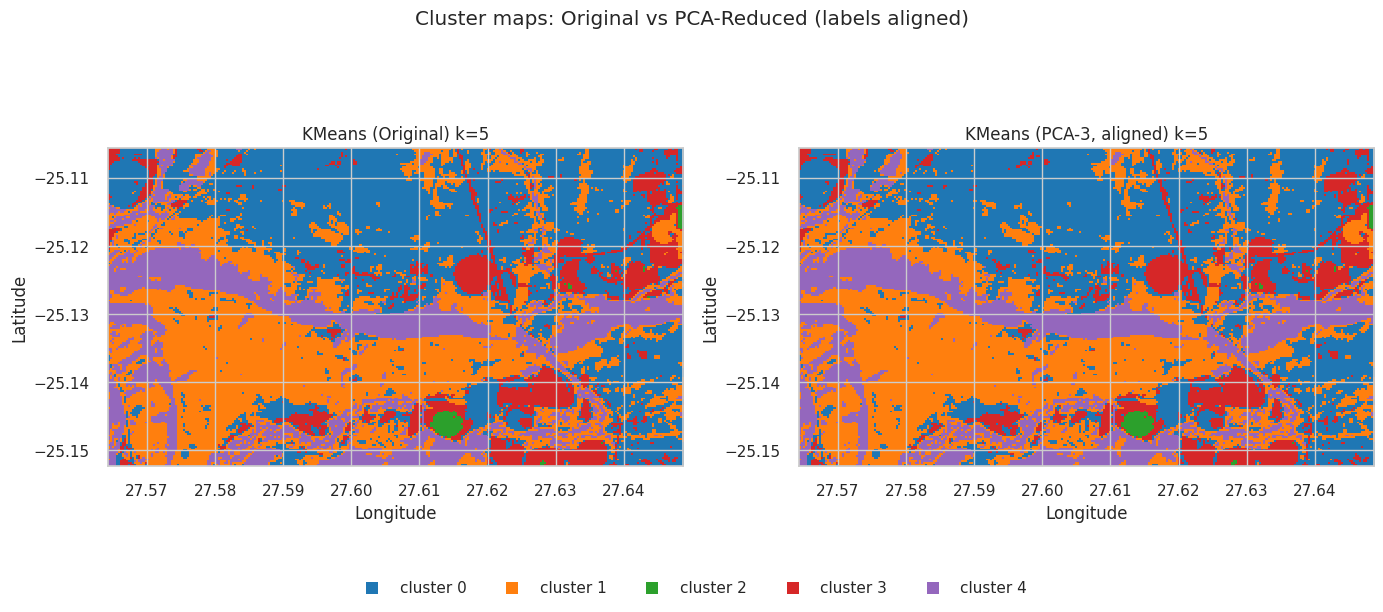

In [ ]:
from matplotlib.colors import ListedColormap
clusters_original_map = labels_original.reshape(size)
clusters_pca_map  = labels_pca_aligned.reshape(size)

cmap = ListedColormap(plt.get_cmap('tab10').colors[:k_final])

fig, axes = plt.subplots(1,2, figsize=(14,6))
im1 = axes[0].imshow(clusters_original_map, cmap=cmap, extent=[xmin,xmax,ymin,ymax], origin='lower', interpolation='nearest')
axes[0].set_title(f'KMeans (Original) k={k_final}')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

im2 = axes[1].imshow(clusters_pca_map, cmap=cmap, extent=[xmin,xmax,ymin,ymax], origin='lower', interpolation='nearest')
axes[1].set_title(f'KMeans (PCA-3, aligned) k={k_final}')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

handles = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=9, markerfacecolor=cmap(i)) for i in range(k_final)]
labels = [f'cluster {i}' for i in range(k_final)]
fig.legend(handles, labels, loc='lower center', ncol=k_final, bbox_to_anchor=(0.5, -0.02))
plt.suptitle('Cluster maps: Original vs PCA-Reduced (labels aligned)')
plt.tight_layout(rect=[0,0.03,1,1])
plt.show()


# **PCA RGB Composite (PC1 - PC3)**

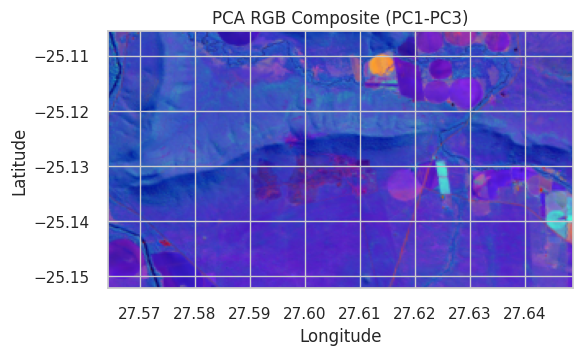

In [ ]:
#PCA RGB Composite (PC1-PC3)
pc1 = pca_data["PC1"].values.reshape(size)
pc2 = pca_data["PC2"].values.reshape(size)
pc3 = pca_data["PC3"].values.reshape(size)

def norm(arr):
    return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr) + 1e-9)

rgb = np.dstack((norm(pc1), norm(pc2), norm(pc3)))
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(rgb, extent=[xmin, xmax, ymin, ymax], aspect=1)
ax.set_title("PCA RGB Composite (PC1-PC3)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


# **NDVI/NDWI Overlays on PCA Composite**

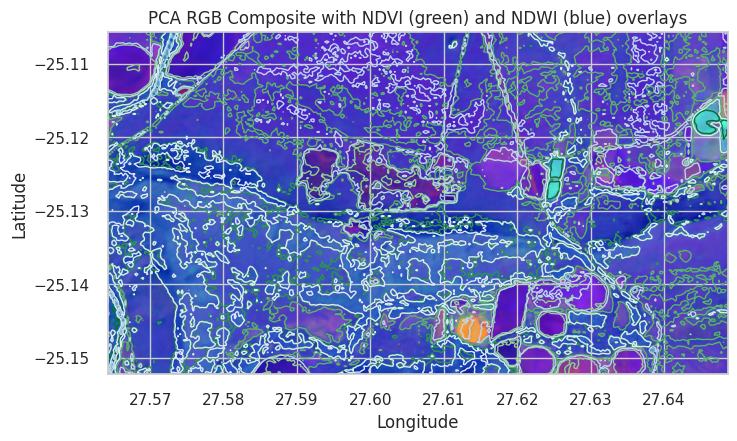

In [ ]:
ndvi_norm = (ndvi_arr - np.nanmin(ndvi_arr)) / (np.nanmax(ndvi_arr) - np.nanmin(ndvi_arr) + eps)
ndwi_norm = (ndwi_arr - np.nanmin(ndwi_arr)) / (np.nanmax(ndwi_arr) - np.nanmin(ndwi_arr) + eps)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb, extent=[xmin, xmax, ymin, ymax], origin='lower')
ax.contour(ndvi_norm, levels=6, linewidths=1, cmap='Greens', extent=[xmin, xmax, ymin, ymax])
ax.contour(ndwi_norm, levels=6, linewidths=1, cmap='Blues', extent=[xmin, xmax, ymin, ymax])

plt.title("PCA RGB Composite with NDVI (green) and NDWI (blue) overlays")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# **Analysis**

The comparison between the clustering structures obtained from the original data and the PCA-reduced data (three principal components) shows that both methids captured broadly similar spatial patterns, but with noticeable differences in compactness and distribution. Using K-Means algorithm with k=5 clusters (determined using Yellowbrick elbow method), the sillhoutte score fot the original dataset was 0.357, while the PCA-reduced dataset achieved a slightly higher score of 0.384. This suggests that the PCA transformation led to more clearly separated and internally cohesive clusters.

Cluster size comparisons reveal how PCA redistribution affected class balance. For instance, Cluster 0 in the original data contained 18447 pixels, whereas the corresponding PCA cluster only contained 4713. Conversely, Cluster 3 grew from 4756 (original) to 18499 (PCA), indicating that dimensionality reduction merged or reorganized certain spectral regions into larger, more homogeneous classes. Despite these numerical shifts, the overall spatial structures between the two clustering results remained largely consistent.

The PCA transformation reduced the dataset from sevn spectral to three orthogonal components while retaining most of the underlying variance. This simplification imporived cluster separation and reduced spectral redundancy, although at the cost of some local detail. The PCA-based clusters appeared smoother and more continuous spatially, whereas the original clusters showed finer texture and local variability, likely reflecting noise and minor spectral differences that PCA filtered out.

# **Brief Interpretation**

PCA-based clustering performed slightly better than clustering on the original data, shown by its higher sillhoutte score (0.384 vs. 0.357) and more stable spatial grouping. The dimensionality reduction effectively condensed key spectral information, allowing K-Means to identify clearer and more distinct regions. However, the redistribution of cluster sizes suggests that PCA emphasizes global variance patterns rather than subtle local variations.

The PCA approach enhanced the stability and interpretability of the clusters, making it a valuable preprocessing step for unsupervised classification of spectral data. the original data, while noisier, still provides finer differentiation that may be important for detailed land-cover or material-specific analysis. Together, these results demonstrate the trade-off between detailed preservation and cluster introduced by dimensionality reduction.